<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/4-training-models/02_overfitting_and_underfitting_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overfitting and Underfitting Fundamentals

What if your data is more complex than a straight line? 

Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called **Polynomial Regression**.

##Setup

In [1]:
# Common imports
import numpy as np
import numpy.random as rnd
import os

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

##Polynomial Regression

Let’s look at an example. First, let’s generate some nonlinear data, based on a simple quadratic equation (plus some noise).

In [2]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

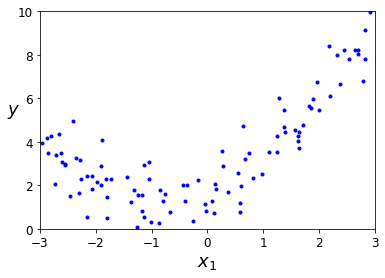

In [3]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Clearly, a straight line will never fit this data properly. 

So let’s use Scikit-Learn’s Poly
nomialFeatures class to transform our training data, adding the square (seconddegree
polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [4]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [5]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` now contains the original feature of X plus the square of this feature. 

Now you can fit a LinearRegression model to this extended training data:

In [6]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [7]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Let's do prediction.

In [8]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

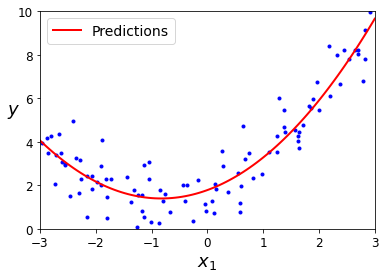

In [9]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do).

This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree.

For example, if there were two features $a$ and $b$, PolynomialFeatures with `degree=3` would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab, a^2b,$ and $ab^2$.

>`PolynomialFeatures(degree=d)` transforms an array containing $n$
features into an array containing $(n + d)! / d!n!$ features, where $n!$ is
the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. Beware of the combinatorial explosion of the number of features!

##Learning Curves